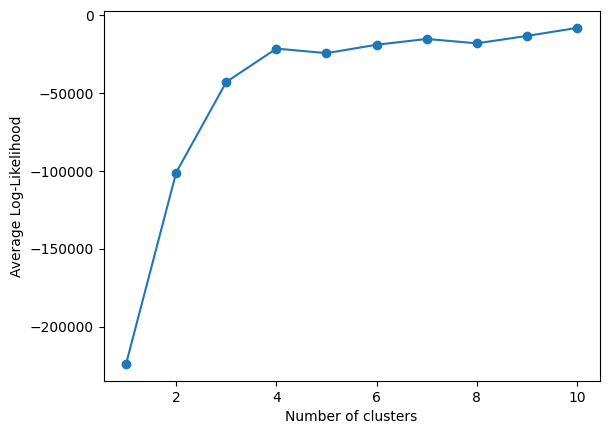

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def gaussian(X, mean, covariance):
    d = X.shape[1]
    # Add a small positive constant to the diagonal of covariance matrix
    covariance += np.eye(d) * 1e-8
    coef = 1 / ((2 * np.pi) ** (d / 2) * np.linalg.det(covariance) ** 0.5)
    diff = X - mean
    exponent = -0.5 * np.sum(np.dot(diff, np.linalg.inv(covariance)) * diff, axis=1)
    return coef * np.exp(exponent)


def initialize_parameters(X, n_components):
    n, d = X.shape
    idx = np.random.choice(n, n_components, replace=False)
    means = X[idx]
    covariances = [
        np.diag(np.ones(d)) for _ in range(n_components)
    ]  # create diagonal matrices
    weights = np.full(n_components, 1 / n_components)
    return means, covariances, weights


def expectation(X, means, covariances, weights):
    n, d = X.shape
    n_components = len(means)
    resp = np.zeros((n, n_components))

    for i in range(n_components):
        resp[:, i] = weights[i] * gaussian(X, means[i], covariances[i])
    epsilon = 1e-8
    resp /= resp.sum(axis=1, keepdims=True) + epsilon

    return resp


def maximization(X, resp, reg=1e-6):
    n, d = X.shape
    n_components = resp.shape[1]

    nk = resp.sum(axis=0)
    weights = nk / n
    means = np.dot(resp.T, X) / nk[:, np.newaxis]

    covariances = []
    for i in range(n_components):
        diff = X - means[i]
        cov = np.dot(resp[:, i] * diff.T, diff) / nk[i]
        cov += np.eye(d) * reg  # add regularization to covariance matrix
        covariances.append(cov)

    return means, covariances, weights


def em_algorithm(X, n_components, max_iter=100, tol=1e-4, reg=1e-6):
    means, covariances, weights = initialize_parameters(X, n_components)

    for _ in range(max_iter):
        old_means = means.copy()
        resp = expectation(X, means, covariances, weights)
        means, covariances, weights = maximization(X, resp, reg=reg)

        if np.linalg.norm(old_means - means) < tol:
            break

    return means, covariances, weights, resp


def cross_validation(X, n_components_range, n_folds=5):
    n = X.shape[0]
    fold_size = n // n_folds
    log_likelihoods = np.zeros((n_folds, len(n_components_range)))

    for fold in range(n_folds):
        validation_indices = np.arange(fold * fold_size, (fold + 1) * fold_size)
        train_indices = np.concatenate(
            (np.arange(0, fold * fold_size), np.arange((fold + 1) * fold_size, n))
        )
        X_train = X[train_indices]
        X_validation = X[validation_indices]

        for i, n_components in enumerate(n_components_range):
            means, covariances, weights, resp_train = em_algorithm(
                X_train, n_components
            )
            resp_validation = expectation(X_validation, means, covariances, weights)
            log_likelihoods[fold, i] = np.sum(
                np.log(np.sum(resp_validation, axis=1) + 1e-8)
            )

    return log_likelihoods.mean(axis=0)

# Load the dataset
df = pd.read_csv("cleaned_bank_transactions.csv")

# Standardize the data
X = df.to_numpy()
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Check for NaN or infinite values
if np.isnan(X).any() or np.isinf(X).any():
    # Replace NaN or infinite values with 0
    X = np.nan_to_num(X, nan=0, posinf=0, neginf=0)

# Find the ideal number of clusters using cross-validation
n_components_range = range(1, 11)
average_log_likelihoods = cross_validation(X, n_components_range=n_components_range)

plt.plot(n_components_range, average_log_likelihoods, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Average Log-Likelihood")
plt.show()

In [1]:
# Fit the Gaussian Mixture Model with the selected number of clusters
n_components = np.argmax(average_log_likelihoods) + 1
means, covariances, weights, resp = em_algorithm(X, n_components)

# Assign each data point to a cluster
cluster_assignments = np.argmax(resp, axis=1)

# Plot the clusters
fig, ax = plt.subplots()
colors = ["r", "g", "b", "y", "c", "m", "k", "orange", "purple", "lime"]
for i in range(n_components):
    cluster_data = X[cluster_assignments == i]
    ax.scatter(
        cluster_data[:, 0], cluster_data[:, 1], c=colors[i], label=f"Cluster {i + 1}"
    )

# Plot the cluster means
for i in range(n_components):
    plt.scatter(
        means[i, 0],
        means[i, 1],
        marker="*",
        s=200,
        c=colors[i],
        edgecolor="k",
        label=f"Mean {i + 1}",
    )

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title(f"Gaussian Mixture Model with {n_components} Clusters")
plt.show()

NameError: name 'np' is not defined